In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from analyzer.model.regression_model import RegressionModel
from data.io import Reader, Saver
from data.plot import Drawer
from analyzer.stat_criterion.stat_criteria import StatCriteria
from data.encoder import Encoder
from data.normalizer import Normalizer
from data import DataPreparation

from statsmodels.stats.outliers_influence import variance_inflation_factor

In [11]:
# Загружаем данные
df = Reader.read_csv('./dataset/df_elite.csv')


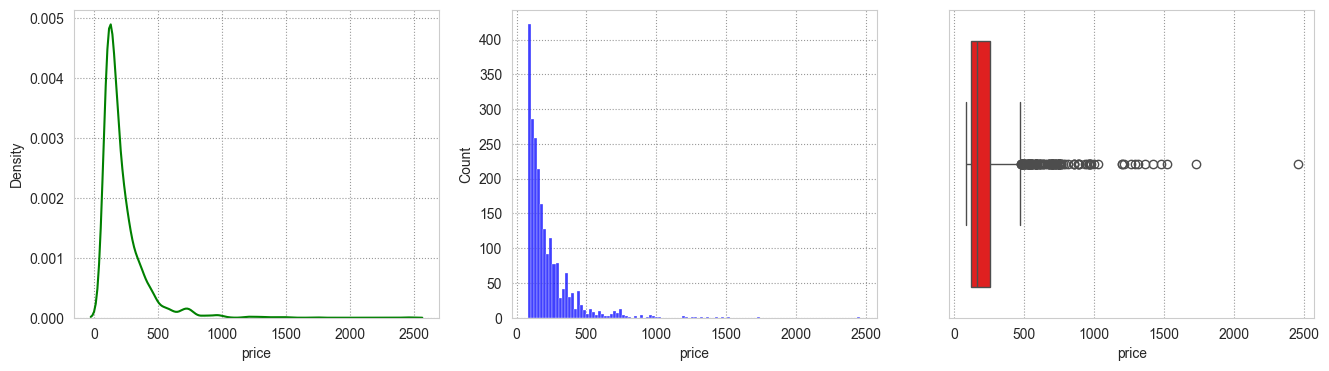

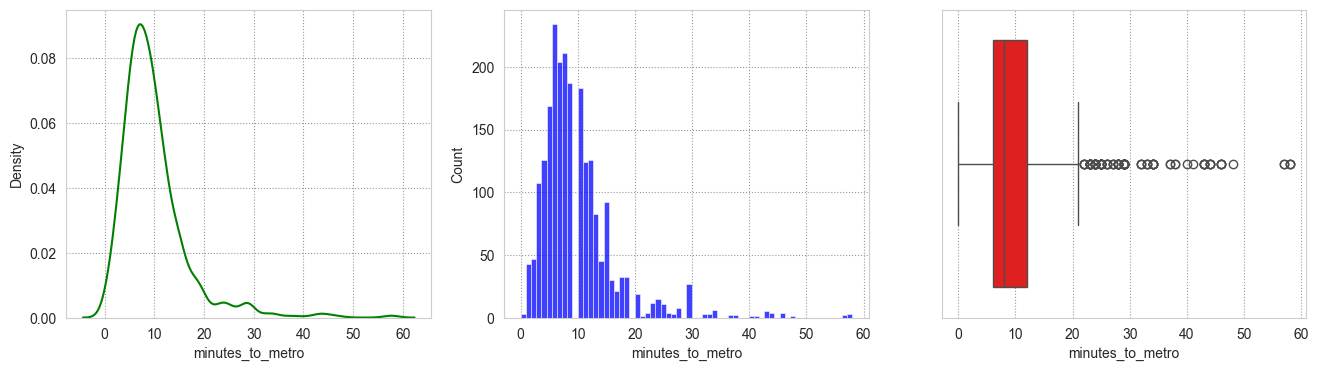

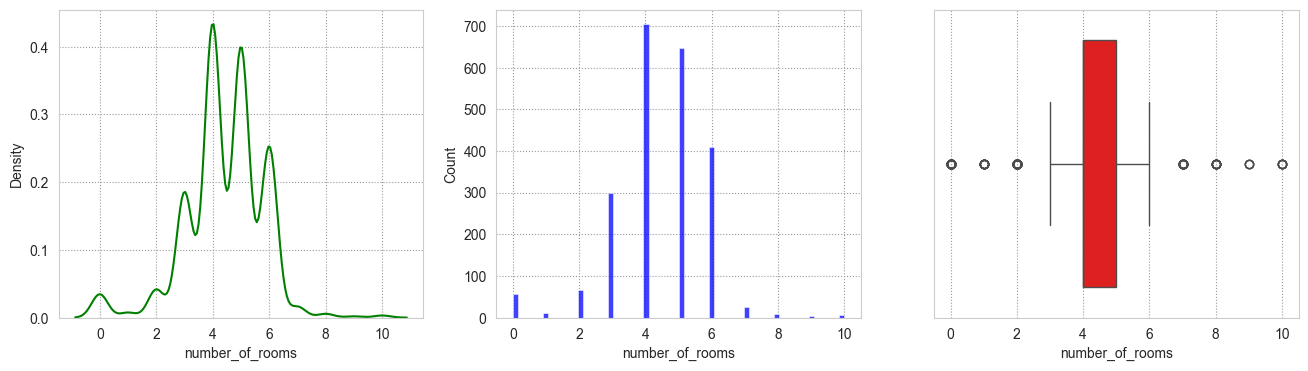

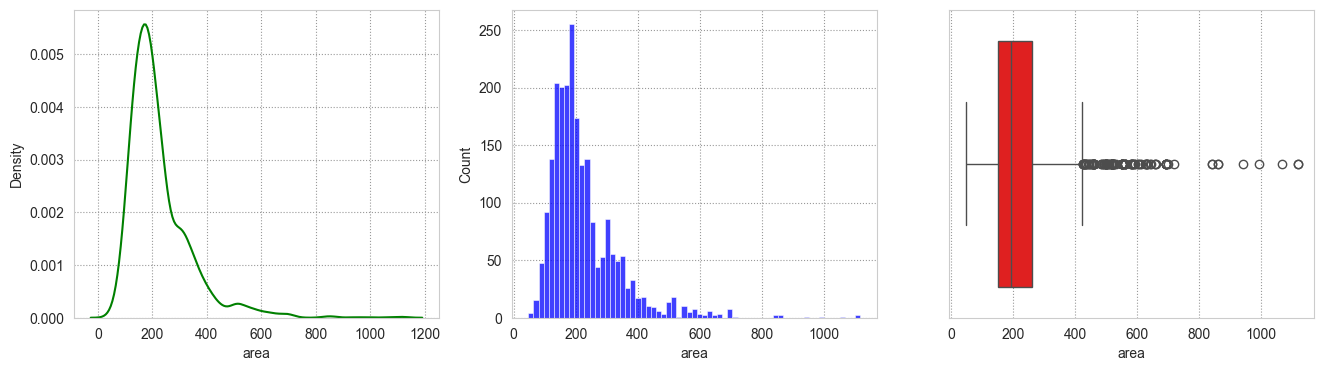

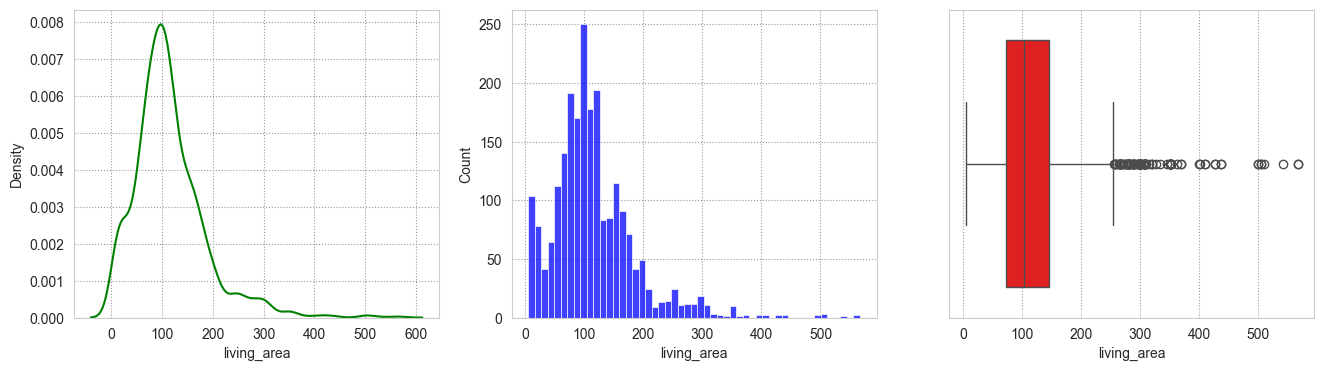

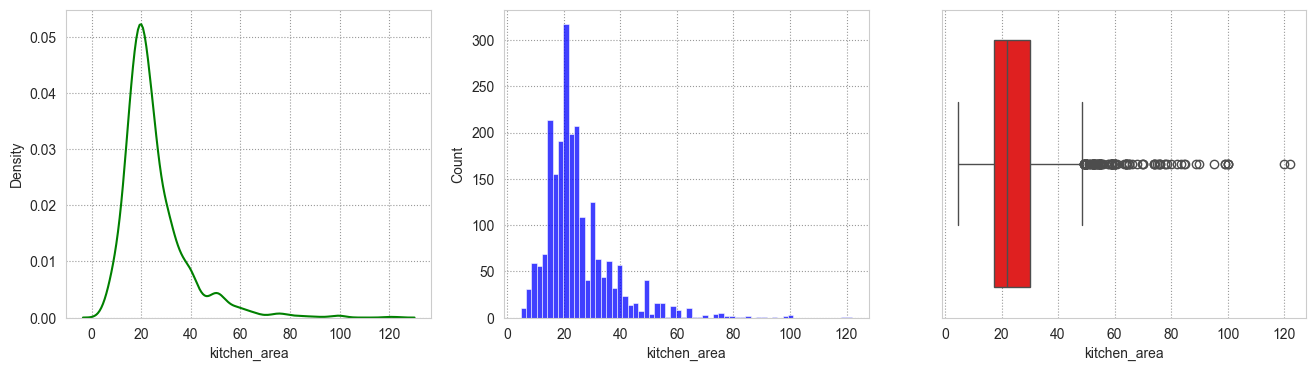

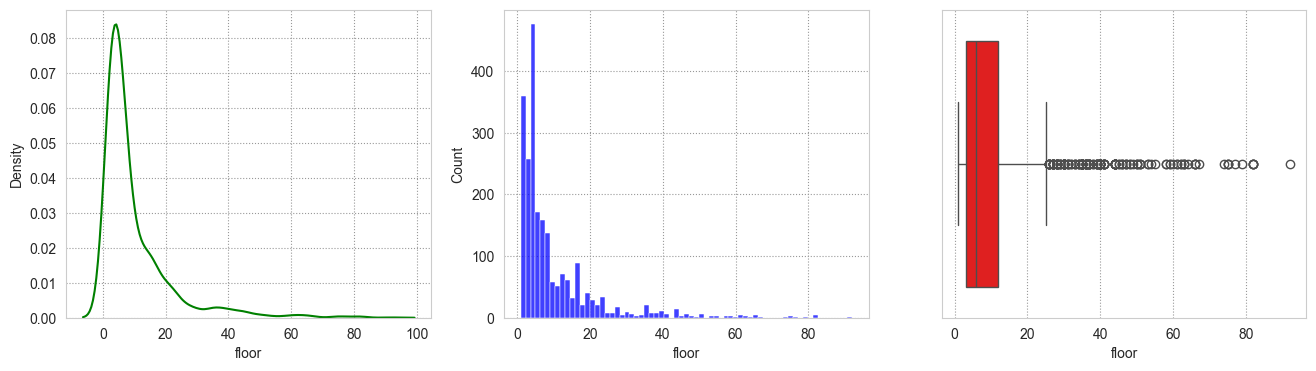

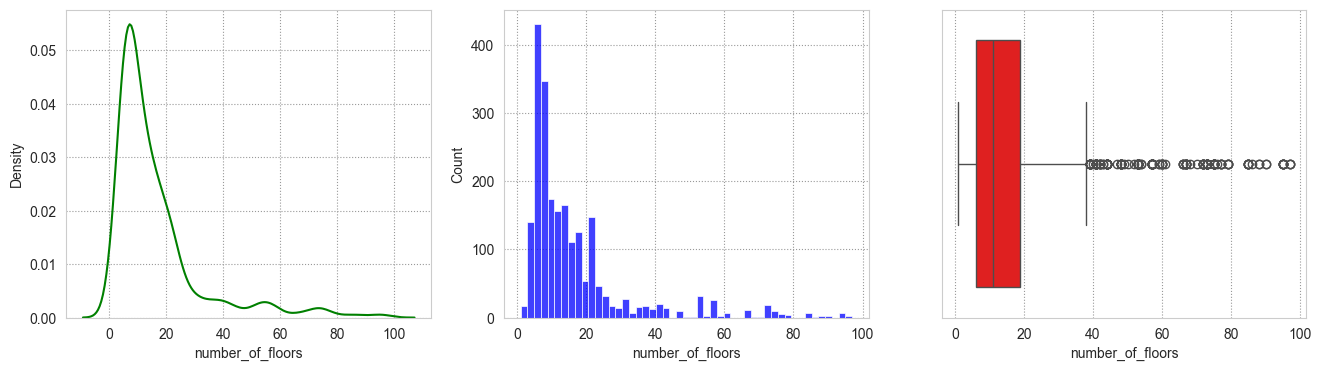

In [12]:
# ещё раз визуально оцениваем обычную недвижимость
Drawer.plot_numeric_seaborn(df)

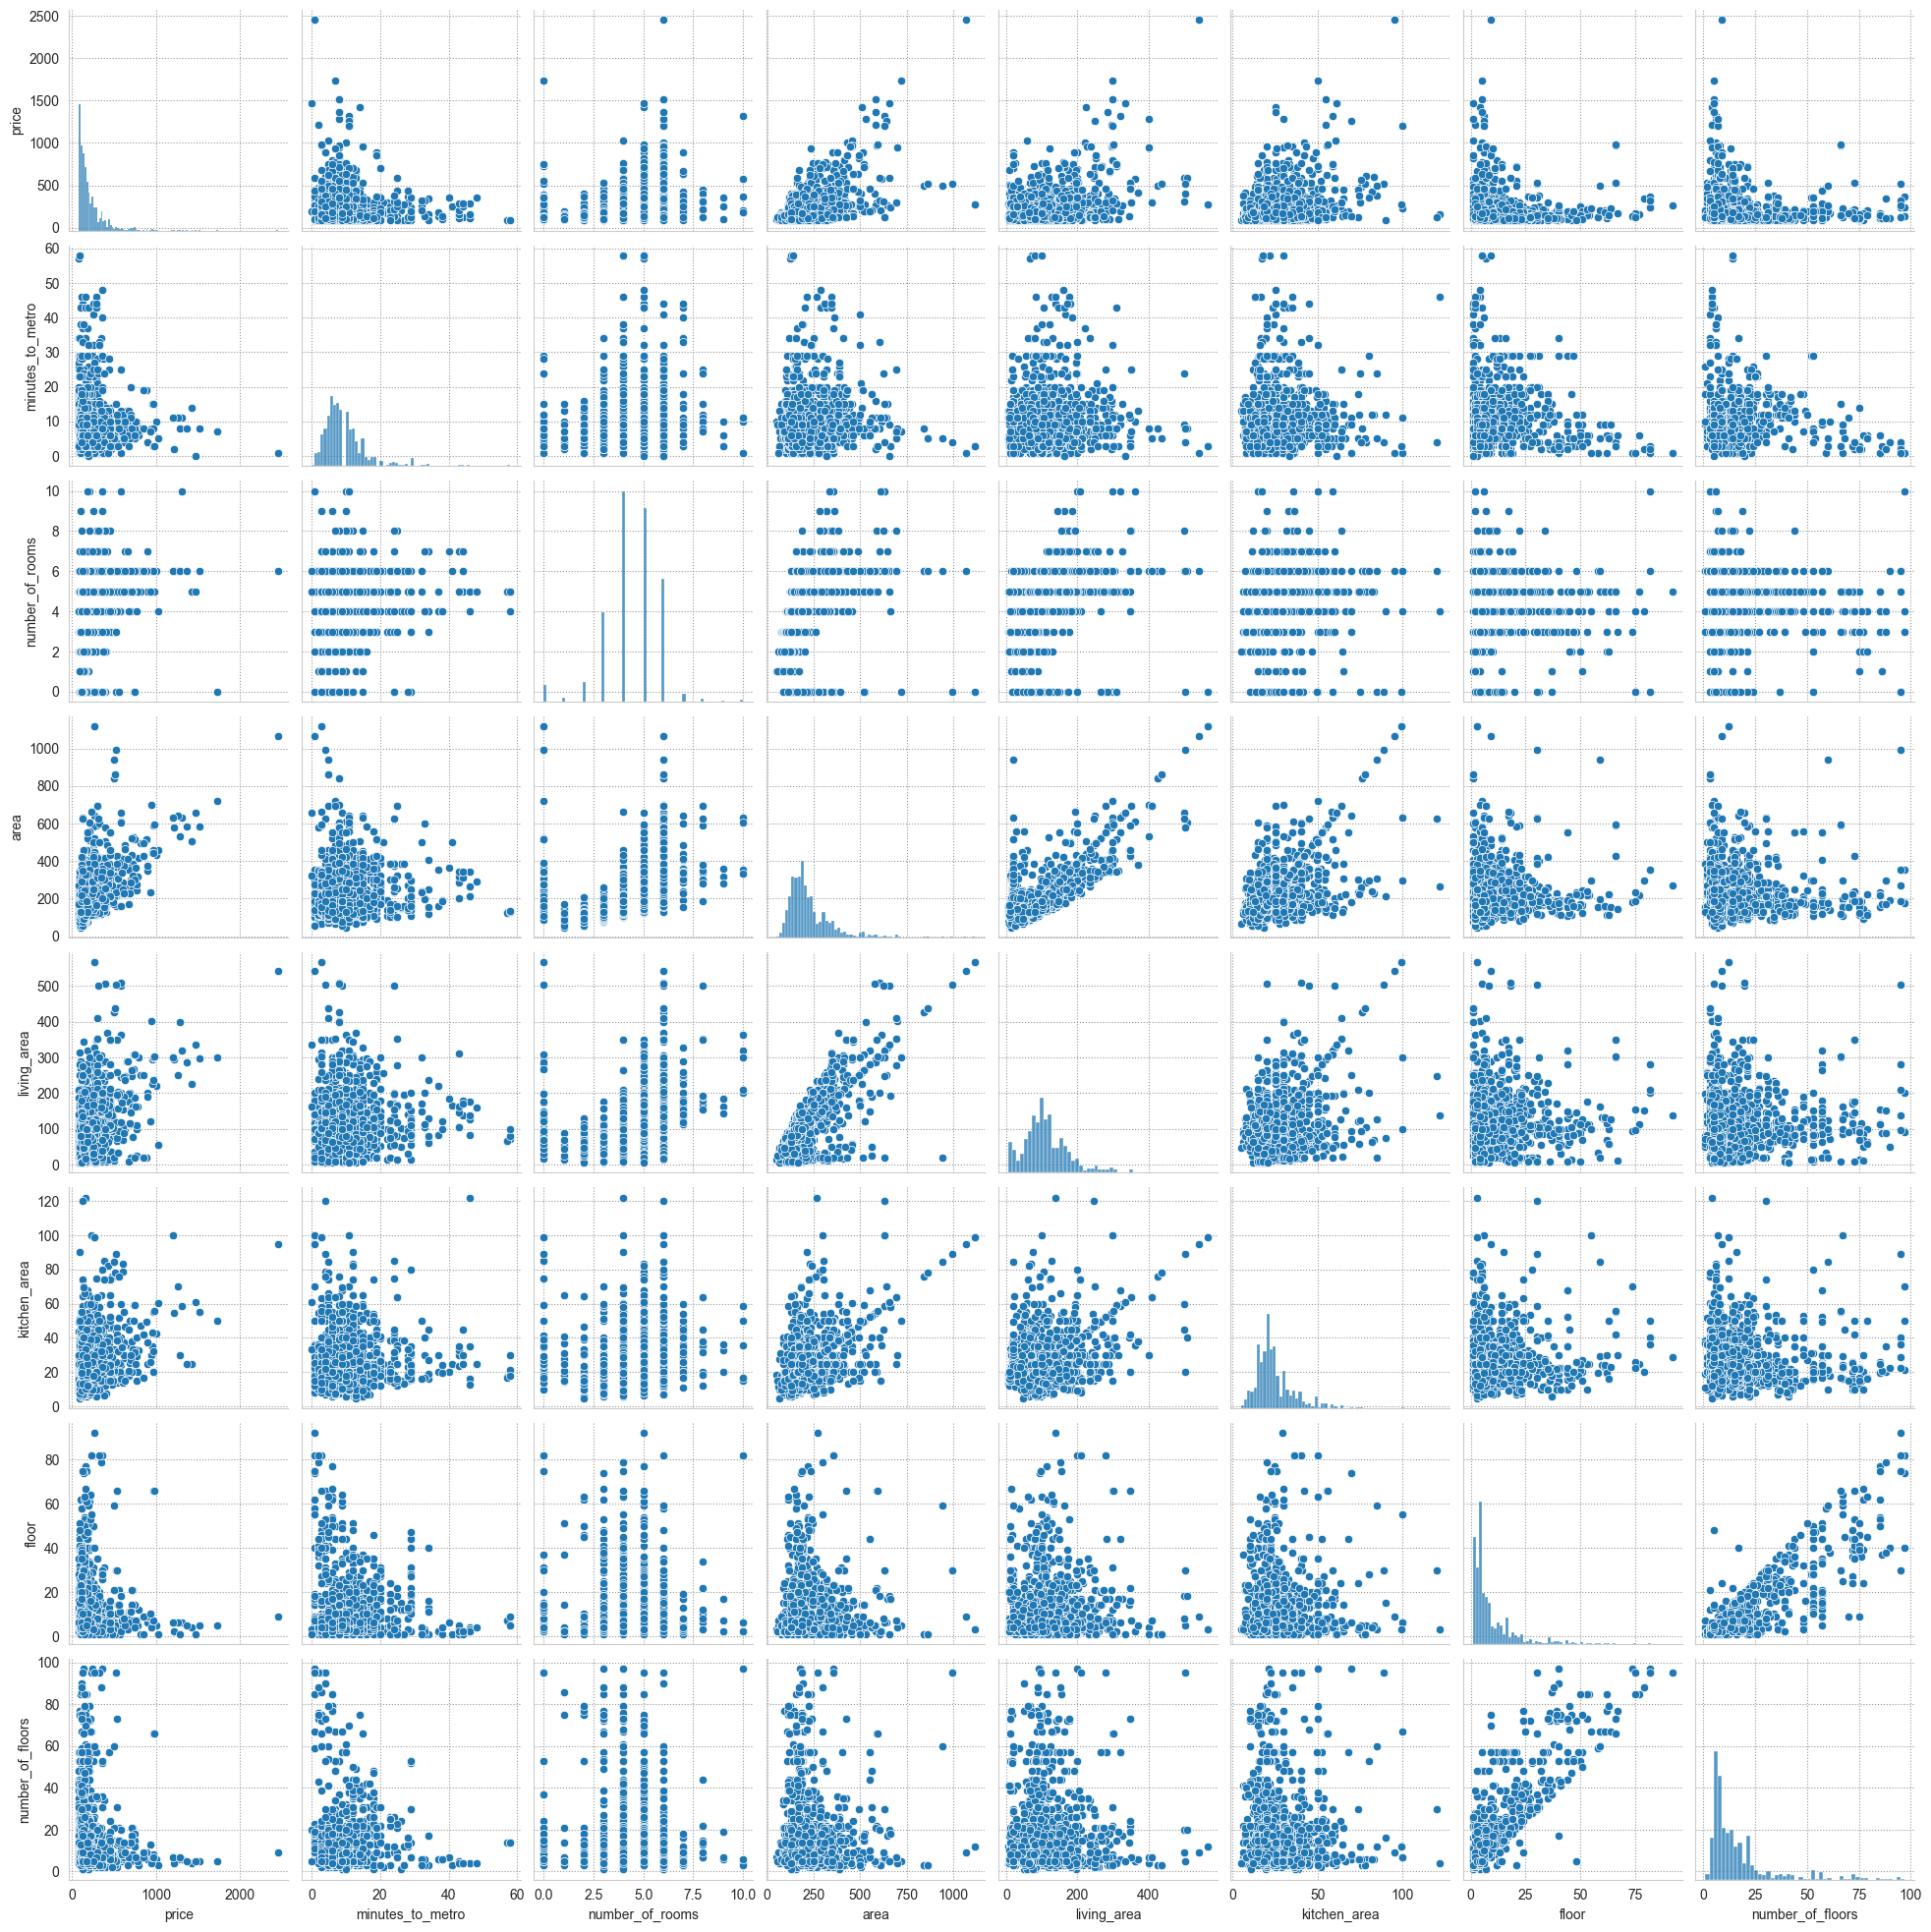

In [13]:
# Исследуем графически зависимость признаков на целевую переменную недвижимости
numeric_col = df.describe().columns
sns.pairplot(df[numeric_col])

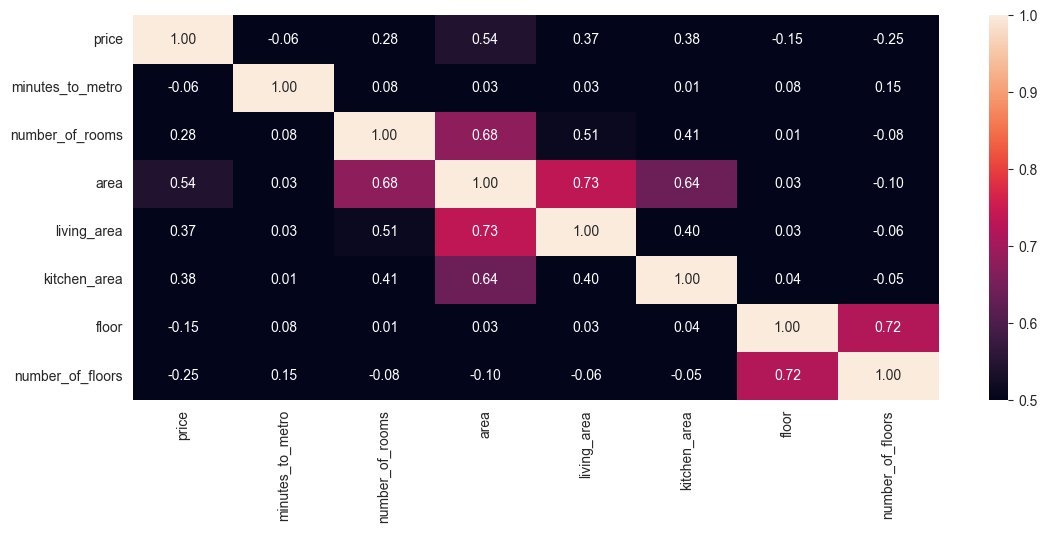

In [14]:
# Исследуем тепловую карту корреляции признаков на целевую переменную для обычной недвижимости
plt.figure(figsize=(13,5))
sns.heatmap(df.corr(method='spearman', numeric_only=True), annot=True, fmt='.2f', vmin=0.5)
plt.show()

Выводы:
1. графически наблюдается связь цены от минут до метро (minutes_to_metro), чем БЛИЖЕ к метро, тем выше цена.
2. по тепловой карте наблюдается положительная корреляция цены от площади (area, living_area, number_of_rooms).
3. наблюдается корреляция признаков: этажа (floor) от этажности аппартаментов (number_of_floors), что избыточно и в дальнейшем можно удалить эти колонки при обнаружении между ними сильной VIF.
4. наблюдается корреляция признаков: площадь (area) коррелирует с жилой площадью (living_area) и с площадью кухни (kitchen_area), также числом комнат (number_of_rooms), что избыточно и в дальнейшем можно удалить эти колонки при обнаружении между ними сильной VIF

In [15]:
# Проверим допущение о мультиколлинеарности
numeric_col = df.drop(columns='price').describe().columns
vif_data = pd.DataFrame()
vif_data.index = numeric_col

vif_data['VIF'] = [variance_inflation_factor(df[numeric_col].values, i) for i in range(len(numeric_col))]
vif_data

,VIF
minutes_to_metro,2.905597
number_of_rooms,7.766630
area,17.115924
living_area,9.035493
kitchen_area,7.643415
floor,6.191350
number_of_floors,6.872840


In [16]:
# Проверим допущение о мультиколлинеарности ещё раз
numeric_col = df.drop(columns=['price', 'living_area', 'kitchen_area', 'number_of_rooms', 'number_of_floors']).describe().columns
vif_data = pd.DataFrame()
vif_data.index = numeric_col

vif_data['VIF'] = [variance_inflation_factor(df[numeric_col].values, i) for i in range(len(numeric_col))]
vif_data

,VIF
minutes_to_metro,2.296103
area,2.529778
floor,1.584655


Вывод: для элитной недвижимости три признака оказались менее 5, то есть с этими признаками можно работать

In [17]:
# Смотрим на колонки с категориальными переменными
df.describe(include='object')

,apartment_type,metro_station,renovation
count,2240,2240,2240
unique,1,203,4
top,Secondary,Спортивная,Designer
freq,2240,122,1341


Выводы:
1. у нас всего 1 тип аппартаментов в датасете - вторичка, поэтому нет смысла учитывать это как признак
2. у нас всего 4 вида ремонта в датасете
3. элитная недвижимость расположена только вблизи третий всех станций метро

In [18]:
column_list = ['metro_station', 'renovation']

for column in column_list:
    groups = []
    for unique_value in df[column].unique():
        groups.append(df[df[column] == unique_value]['price'])
    StatCriteria().kruskal(groups)

kruskal
statistic = 682.283
Медианы всех групп не равны (p-value = 0.000).
kruskal
statistic = 41.092
Медианы всех групп не равны (p-value = 0.000).


Вывод: на стоимость elite недвижимости влияют все категориальные переменные такие как:
1. metro_station,
2. renovation,

поэтому их все придётся учитывать при проведении регрессии.

In [19]:
df['renovation'] = Encoder().labelEncoder(df['renovation'])
df['metro_station'], _ = Encoder().leaveOneOutEncoder(df['metro_station'], df['price'])

In [20]:
# проверяем датасет
df.head(5)

,price,apartment_type,metro_station,minutes_to_metro,number_of_rooms,area,living_area,kitchen_area,floor,number_of_floors,renovation
0,329.868,Secondary,426.222569,7,4,214.2,110.4,20.0,3,5,3
1,155.000,Secondary,195.584816,7,3,163.0,120.0,20.0,33,53,1
2,125.000,Secondary,233.709529,5,5,170.0,88.1,20.7,4,5,1
3,117.000,Secondary,219.738596,10,4,128.7,70.0,19.3,4,7,1
4,225.000,Secondary,236.792829,12,5,173.0,89.6,15.0,4,12,1


In [21]:
# подготавливаем данные
exclude_features = ['price', 'apartment_type', 'living_area', 'kitchen_area', 'number_of_rooms']
target = ['price']
X_train, X_test, y_train, y_test = DataPreparation().train_test_split(df, exclude_features, target)

# проводим нормализацию (логарифмирование)
X_train, X_test, y_train, y_test = Normalizer().log1p_norm(X_train, X_test, y_train, y_test)
X_train, X_test, _ = Normalizer().MinMaxScaler(X_train, X_test)
X_train, X_test, y_train, y_test = Normalizer().reset_index(X_train, X_test, y_train, y_test)

In [22]:
# Применяем готовую линейную регрессию из библиотеки statsmodels
y_test, y_pred, _ = RegressionModel().OLS(X_train, X_test, y_train, y_test, prepend=False)
residuals = y_test - y_pred

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.474
Model:                            OLS   Adj. R-squared:                  0.473
Method:                 Least Squares   F-statistic:                     251.7
Date:                Fri, 07 Feb 2025   Prob (F-statistic):          1.59e-229
Time:                        23:08:37   Log-Likelihood:                -852.34
No. Observations:                1680   AIC:                             1719.
Df Residuals:                    1673   BIC:                             1757.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
metro_station        1.1296      0.060  

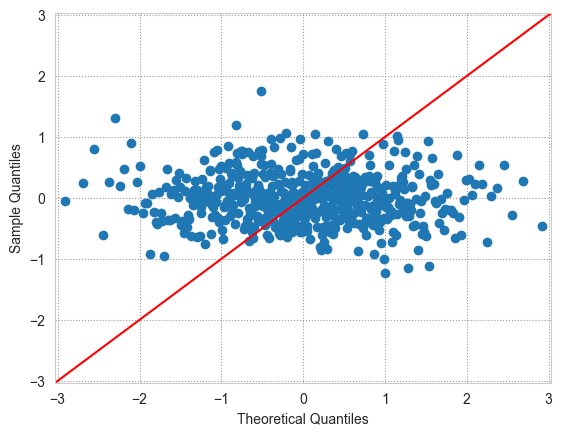

In [23]:
# Проверка на нормальность остатков
fig = sm.qqplot(residuals, line='45')
plt.show()

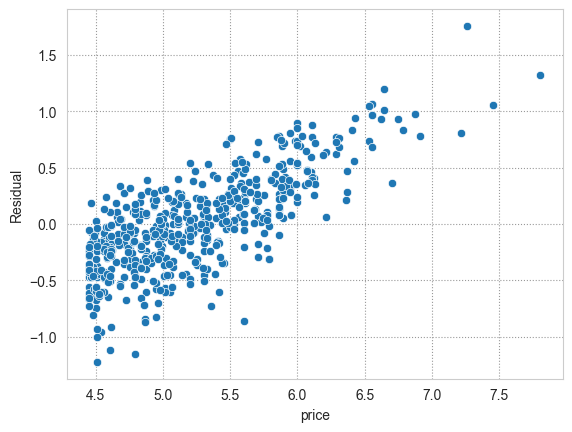

In [24]:
# Проверка на гомоскедастичность визуально
sns.scatterplot(x = y_test.squeeze(), y = residuals.squeeze())
plt.ylabel("Residual")
plt.show()

In [25]:
y_test, y_pred, _ = RegressionModel().Lasso(X_train, X_test, y_train, y_test, alpha=0.01)
residuals = y_test - y_pred

R²: 0.451
MAE: 0.34
MAPE: 7%
RMSE: 0
MSE: 0
__________
Коэффициенты Lasso-регрессии:
metro_station: 0.89
minutes_to_metro: -0.00
area: 1.69
floor: -0.00
number_of_floors: -0.01
renovation: -0.00


Выводы: не влияют minutes_to_metro, floor, number_of_floor